In [61]:
import json
import re

In [62]:
def count_output(file_path):
    data_list = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Parse each line as JSON
            data = json.loads(line.strip())
            data_list.append(data)
    print("len:", len(data_list))

In [63]:
count_output("../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2_BA.txt")
count_output("../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2.txt")
count_output("../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2_format1_BA.txt")
count_output("../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2_format1.txt")

len: 3300
len: 3300
len: 3300
len: 3300


In [64]:
def read_output_file(path, criterion, reverse=False):
    assert criterion in ['sound', 'rhythm', 'pronunciation']
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct, count_incorrect, error = 0, 0, 0, 0
    predictions = []
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']
        
        verdict_text = output['processed']
        assert verdict_text in ['A', 'B', 'C']
        
        if verdict_text == "A":
            if audio_a[criterion] > audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                count_incorrect += 1
                evaluation = "incorrect"
        elif verdict_text == "B":
            if audio_a[criterion] < audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                count_incorrect += 1
                evaluation = "incorrect"
        else:
            evaluation = 'error'
            error += 1
        count_all += 1
        predictions.append([evaluation, verdict_text, audio_a[criterion], audio_b[criterion]])
    print("total:", count_all)
    print("error: {:.2f}%".format(error/count_all*100))
    print("accuracy: {:.2f}%".format(count_correct/count_all*100))
    return predictions

In [67]:
criterion = 'pronunciation' # 'sound', 'rhythm', 'pronunciation'
predictions_ab = read_output_file(f"../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2.processed.txt", criterion)

total: 3300
error: 13.27%
accuracy: 42.06%


In [46]:
predictions_ba = read_output_file(f"../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2_BA.processed.txt", criterion, reverse=True)

total: 3300
error: 14.03%
accuracy: 40.58%


In [45]:
abba_correct, abba_incorrect, abba_error = 0, 0, 0
for x in predictions_ab + predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    elif x[0] == 'error':
        abba_error += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect+abba_error)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect+abba_error)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect+abba_error)*100))

total: 6600
correct: 41.32%
incorrect: 45.03%


In [39]:
# count_A, count_B, count = 0, 0, 0
# for x in predictions_ab:
#     count += 1
#     if x[1] == "[[A]]":
#         count_A += 1
#     elif x[1] == "[[B]]":
#         count_B += 1
#     else:
#         raise Exception()
# print("percentage_A: {:.2f}%".format(count_A/count*100))
# print("percentage_B: {:.2f}%".format(count_B/count*100))

In [40]:
# count_A, count_B, count = 0, 0, 0
# for x in predictions_ba:
#     count += 1
#     if x[1] == "[[A]]":
#         count_A += 1
#     elif x[1] == "[[B]]":
#         count_B += 1
#     else:
#         raise Exception()
# print("percentage_A: {:.2f}%".format(count_A/count*100))
# print("percentage_B: {:.2f}%".format(count_B/count*100))

In [41]:
# predictions_ab = predictions_ab[:len(predictions_ba)]
# consistent, bias_A, bias_B = 0, 0, 0
# correct_given_consistent = 0
# for ab, ba in zip(predictions_ab, predictions_ba):
#     if ab[0] == ba[0]:
#         consistent += 1
#         if ab[0] == 'correct':
#             correct_given_consistent += 1
#     else:
#         if ab[1] == "[[A]]" and ba[1] == "[[A]]":
#             bias_A += 1
#         elif ab[1] == "[[B]]" and ba[1] == "[[B]]":
#             bias_B += 1
#         else:
#             raise Exception("logic error")
# assert consistent + bias_A + bias_B == len(predictions_ab)

In [42]:
# print("consistent: {:.2f}%".format(consistent/len(predictions_ab)*100))
# print("bias_A:     {:.2f}%".format(bias_A/len(predictions_ab)*100))
# print("bias_B:     {:.2f}%".format(bias_B/len(predictions_ab)*100))
# print("P(correct|consistent): {:.2f}%".format(correct_given_consistent/consistent*100))

# System-level Correlation

In [50]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [51]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

Pearson Correlation: -0.102
Spearman Correlation: 0.098


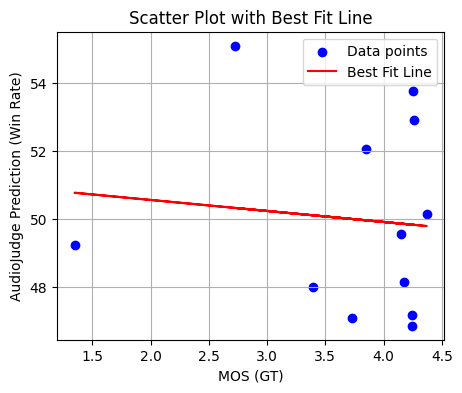

In [55]:
pred_by_system, gts_by_system = {}, {}

reverse = False
path = f"../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2.processed.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_a, audio_b = output['data']
    model_a = audio_a['system']
    model_b = audio_b['system']
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []
        
    verdict_text = output['processed']
    assert verdict_text in ['A', 'B', 'C']
        
    if verdict_text == "A":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "B":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]
    elif verdict_text == "C":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    else:
        raise Exception()

    gts_by_system[model_a] += [audio_a[criterion]]
    gts_by_system[model_b] += [audio_b[criterion]]

################################################################################
reverse = True
path = f"../experiments/thaimos/ab_testing/diffall_typhoon2_prompt2_BA.processed.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_b, audio_a = output['data']
    model_a = audio_a['system']
    model_b = audio_b['system']
    
    verdict_text = output['processed']
    assert verdict_text in ['A', 'B', 'C']
        
    if verdict_text == "A":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "B":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]
    elif verdict_text == "C":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    else:
        raise Exception()

    gts_by_system[model_a] += [audio_a[criterion]]
    gts_by_system[model_b] += [audio_b[criterion]]
        
system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)